**计算polya尾巴上的非A碱基修饰**

In [1]:
from collections import defaultdict, namedtuple, Counter
import pickle
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import pyranges as pr
import pysam
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import variation, gaussian_kde, pearsonr, mannwhitneyu
from Bio import SeqIO

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(filename)s: %(message)s',
                    datefmt='%m/%d/%Y %I:%M:%S %p',
                    )

In [3]:
# 设置全局字体
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
gene_model_bed = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)
gene_model = gene_model.set_index(['Name'])
gene_model.head()

,Chromosome,Start,End,Score,Strand
Name,,,,,
AT1G01010,1,3629,5899,.,+
AT1G01020,1,6786,9130,.,-
AT1G03987,1,11099,11372,.,+
AT1G01030,1,11647,13714,.,-
AT1G01040,1,23119,31227,.,+


In [5]:
# reverse complement

old_chars = "ACGT"
replace_chars = "TGCA"
tab = str.maketrans(old_chars,replace_chars)
def reverse_complement(seq):
    return seq.translate(tab)[::-1]

In [6]:
# get high qualty reads
# number pass >= 10

ccs_bam = '/public/home/mowp/data/total_RNA/pacbio_cdna/raw_data/totalRNA.ccs.bam'
high_qual_reads = set()
with pysam.AlignmentFile(ccs_bam, 'rb', check_sq=False) as inbam:
    for read in inbam:
        if read.get_tag('np') >= 10:
            high_qual_reads.add(read.query_name)

In [133]:
# 获取pacbio polyA序列

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/aligned_data/totalRNA.polyA_tail.result.tsv'
df = pd.read_csv(infile, sep='\t')

df['read_id'] = df['read_core_id'].map(lambda x: x.split(',')[0])

df.drop_duplicates('read_id', False, inplace=True)

df = df.loc[:, ['read_id', 'polya_start_base', 'polya_end_base']]

polya_info = {item[0]: (item[1], item[2]) for item in df.values}

In [32]:
%%time

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/aligned_data/totalRNA.polyA_tail.fasta'

polya_seq_dict = {}
for read in SeqIO.parse(infile, 'fasta'):
    if read.id in high_qual_reads:
        polya_seq = str(read.seq)
        polya_seq_dict[read.id] = polya_seq

CPU times: user 22.7 s, sys: 781 ms, total: 23.5 s
Wall time: 23.3 s


In [45]:
%%time

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'

n = 0
nucleotide_freq = defaultdict(lambda: Counter())
non_a_reads_count = defaultdict(lambda: Counter())
total_count = Counter()
with pysam.AlignmentFile(infile, 'rb') as inbam:

    for read in inbam:
        polya_len = read.get_tag('pa')
        read_gene_id = read.get_tag('gi')
        if read.query_name in polya_seq_dict:  
            if polya_len <= 150:
                polya_len = polya_len//3*3
                polya_seq = polya_seq_dict[read.query_name]
                nucleotide_freq[polya_len] += Counter(polya_seq)
                total_count += Counter(polya_seq)
                
                if 'T' in polya_seq:
                    non_a_reads_count[polya_len]['T'] += 1
                if 'C' in polya_seq:
                    non_a_reads_count[polya_len]['C'] += 1
                if 'G' in polya_seq:
                    non_a_reads_count[polya_len]['G'] += 1
                non_a_reads_count[polya_len]['n'] += 1
                
                n += 1

CPU times: user 1min 2s, sys: 227 ms, total: 1min 2s
Wall time: 1min 2s


In [46]:
n

1260759

# nucleotide freq in different length

In [47]:
x, tt, gg, cc = [], [], [], []
for polya_len in range(15, 150):
    
    total = nucleotide_freq[polya_len]['T']+nucleotide_freq[polya_len]['C']+nucleotide_freq[polya_len]['G']+nucleotide_freq[polya_len]['A']
    if total > 0:
        x.append(polya_len)
        tt.append(nucleotide_freq[polya_len]['T']/total)
        gg.append(nucleotide_freq[polya_len]['G']/total)
        cc.append(nucleotide_freq[polya_len]['C']/total)

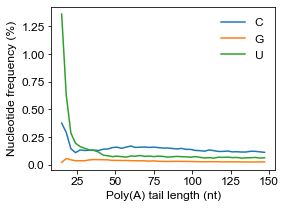

In [48]:
@ticker.FuncFormatter
def formatter(x, pos):
    if x==0:
        return x
    return f'{x*100:0.2f}'
plt.figure(figsize=(4, 3))
plt.plot(x, cc, label='C')
plt.plot(x, gg, label='G')
plt.plot(x, tt, label='U')
plt.legend(frameon=False)
plt.ylabel('Nucleotide frequency (%)')
plt.xlabel('Poly(A) tail length (nt)')
plt.gca().get_yaxis().set_major_formatter(formatter)

# non-A read frequency

In [49]:
x, tt, gg, cc = [], [], [], []
for polya_len in range(15, 150):
    total = non_a_reads_count[polya_len]['n']
    if total > 0:
        x.append(polya_len)
        tt.append(non_a_reads_count[polya_len]['T']/total)
        gg.append(non_a_reads_count[polya_len]['G']/total)
        cc.append(non_a_reads_count[polya_len]['C']/total)

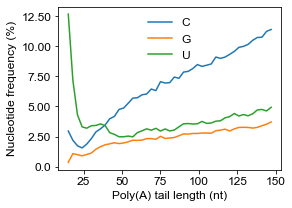

In [50]:
@ticker.FuncFormatter
def formatter(x, pos):
    if x==0:
        return x
    return f'{x*100:0.2f}'
plt.figure(figsize=(4, 3))
plt.plot(x, cc, label='C')
plt.plot(x, gg, label='G')
plt.plot(x, tt, label='U')
plt.legend(frameon=False)
plt.ylabel('Nucleotide frequency (%)')
plt.xlabel('Poly(A) tail length (nt)')
plt.gca().get_yaxis().set_major_formatter(formatter)

# nucleotide freq

In [37]:
total_count

Counter({'A': 105438402, 'G': 32653, 'T': 77933, 'C': 143787})

In [38]:
total = total_count['T']+total_count['C']+total_count['G']+total_count['A']
x, y = [], []
for i, base in enumerate(('C', 'G', 'T')):
    x.append(i)
    y.append(total_count[base]/total)

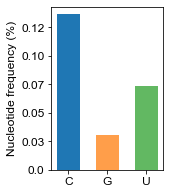

In [39]:
plt.figure(figsize=(2, 3))
plt.bar(x, y, width=.6, color=['#1F77B4', '#FF9E4A', '#62B862'])
plt.xticks(x, ['C', 'G', 'U'])
plt.ylabel('Nucleotide frequency (%)')
plt.gca().get_yaxis().set_major_formatter(formatter)

In [52]:
%%time

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'

fwd_nucleotide_pos = defaultdict(lambda: Counter())
with pysam.AlignmentFile(infile, 'rb') as inbam:

    for read in inbam:
        polya_len = read.get_tag('pa')
        read_gene_id = read.get_tag('gi')
        if read.query_name in polya_seq_dict:

            polya_seq = polya_seq_dict[read.query_name]
            for pos, nucleotide in enumerate(polya_seq, 1):
                if pos > 150:
                    break
                fwd_nucleotide_pos[pos][nucleotide] += 1

CPU times: user 2min 54s, sys: 326 ms, total: 2min 54s
Wall time: 2min 54s


In [53]:
x, tt, gg, cc = [], [], [], []
for pos in range(5, 150):
    
    total = fwd_nucleotide_pos[pos]['T']+fwd_nucleotide_pos[pos]['C']+fwd_nucleotide_pos[pos]['G']+fwd_nucleotide_pos[pos]['A']
    if total > 0:
        x.append(pos)
        tt.append(fwd_nucleotide_pos[pos]['T']/total)
        gg.append(fwd_nucleotide_pos[pos]['G']/total)
        cc.append(fwd_nucleotide_pos[pos]['C']/total)

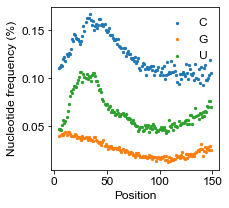

In [54]:
@ticker.FuncFormatter
def formatter(x, pos):
    if x==0:
        return x
    return f'{x*100:0.2f}'

plt.figure(figsize=(3, 3))
plt.scatter(x, cc, label='C', s=5)
plt.scatter(x, gg, label='G', s=5)
plt.scatter(x, tt, label='U', s=5)
plt.legend(frameon=False)
plt.ylabel('Nucleotide frequency (%)')
plt.xlabel('Position')
plt.gca().get_yaxis().set_major_formatter(formatter)

In [55]:
%%time

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'

rev_nucleotide_pos = defaultdict(lambda: Counter())
with pysam.AlignmentFile(infile, 'rb') as inbam:

    for read in inbam:
        polya_len = read.get_tag('pa')
        read_gene_id = read.get_tag('gi')
        if read.query_name in polya_seq_dict:
                
            polya_seq = polya_seq_dict[read.query_name]
            for pos, nucleotide in enumerate(polya_seq[::-1], 1):
                if pos > 150:
                    break
                rev_nucleotide_pos[pos][nucleotide] += 1

CPU times: user 2min 54s, sys: 353 ms, total: 2min 54s
Wall time: 2min 54s


In [140]:
x, tt, gg, cc = [], [], [], []
for pos in range(0, 25):
    
    total = rev_nucleotide_pos[pos]['T']+rev_nucleotide_pos[pos]['C']+rev_nucleotide_pos[pos]['G']+rev_nucleotide_pos[pos]['A']
    if total > 0:
        x.append(pos)
        tt.append(rev_nucleotide_pos[pos]['T']/total)
        gg.append(rev_nucleotide_pos[pos]['G']/total)
        cc.append(rev_nucleotide_pos[pos]['C']/total)

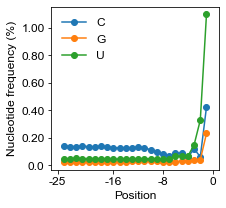

In [146]:
@ticker.FuncFormatter
def formatter(x, pos):
    if x==0:
        return x
    return f'{x*100:0.2f}'
plt.figure(figsize=(3, 3))
# plt.scatter(x, cc, label='C', s=5)
# plt.scatter(x, gg, label='G', s=5)
# plt.scatter(x, tt, label='U', s=5)

plt.plot(x, cc, label='C', marker='o')
plt.plot(x, gg, label='G', marker='o')
plt.plot(x, tt, label='U', marker='o')
plt.legend(frameon=False)
plt.ylabel('Nucleotide frequency (%)')
plt.xlabel('Position')
plt.gca().get_yaxis().set_major_formatter(formatter)
plt.xlim(26, -1)
plt.xticks(np.linspace(0, 25, 4, dtype='int'),  np.linspace(0, 25, 4, dtype='int')*-1)
plt.show()

In [58]:
def plot_freq_pos(ax, x, cc, gg, tt, ylabel=None):
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.set_xlabel('Position')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.scatter(x, cc, label='C', s=5)
    ax.scatter(x, gg, label='G', s=5)
    ax.scatter(x, tt, label='U', s=5)
    ax.yaxis.set_major_formatter(formatter)

    
def get_data(nucleotide_pos, start, end):
    x, tt, gg, cc = [], [], [], []
    for pos in range(start, end):

        total = nucleotide_pos[pos]['T']+nucleotide_pos[pos]['C']+nucleotide_pos[pos]['G']+nucleotide_pos[pos]['A']
        if total > 0:
            x.append(pos)
            tt.append(nucleotide_pos[pos]['T']/total)
            gg.append(nucleotide_pos[pos]['G']/total)
            cc.append(nucleotide_pos[pos]['C']/total)
    return x, tt, gg, cc

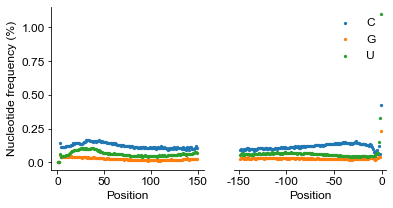

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
x, tt, gg, cc = get_data(fwd_nucleotide_pos, 0, 150)
plot_freq_pos(ax[0], x, cc, gg, tt, ylabel='Nucleotide frequency (%)')
ax[0].set_xticks(np.linspace(0, 150, 4, dtype='int'))


x, tt, gg, cc = get_data(rev_nucleotide_pos, 0, 150)
plot_freq_pos(ax[1], x, cc, gg, tt)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_ticks_position('none')
plt.xlim(155, -5)
plt.xticks(np.linspace(0, 150, 4, dtype='int'),  np.linspace(0, 150, 4, dtype='int')*-1)
plt.setp(ax[1].get_yticklabels(), visible=False)
plt.legend(frameon=False)

In [93]:
STRAND_TO_BOOL = {'-': True, '+': False}
def get_nucleotide_freq(infile, gene_id, nucleotide, log=False):
    chrom, start, end, _, gene_strand = gene_model.loc[gene_id, :].values
    
    totol_count = 0
    nucleotide_count = 0
    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            if read.query_name in polya_seq_dict:

                polya_seq = polya_seq_dict[read.query_name]
                read_gene_id = read.get_tag('gi')
                if read_gene_id != gene_id:
                    continue
                    
                if nucleotide in polya_seq:
                    nucleotide_count += 1
                totol_count += 1
                
                if log:
                    print(polya_seq)
                                
    return nucleotide_count, totol_count, gene_id

# mRNA half life

In [113]:
infile = '/public/home/mowp/data/total_RNA/notebook/mRNA_half_life/TPC_Global_mRNA_Decay.tsv'
tpc_half_life = pd.read_csv(infile, sep='\t')
tpc_half_life['gene_id'] = tpc_half_life['gene_id'].str.upper()

# uridylated

In [94]:
# multi run

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'

results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in gene_model.index:
        results.append(e.submit(get_nucleotide_freq, infile, gene_id, 'T'))

In [ ]:
get_nucleotide_freq(infile, 'AT3G22530', 'T', log=True)

In [95]:
uridylated_results = []
for res in results:
    result = res.result()
    if result[1] >= 10:
        uridylated_results.append(result)

In [96]:
uridylated_results = pd.DataFrame(uridylated_results, columns=['nucleotide_count', 'total_count', 'gene_id'])

In [98]:
uridylated_results['freq'] = uridylated_results['nucleotide_count']/uridylated_results['total_count']

<AxesSubplot:>

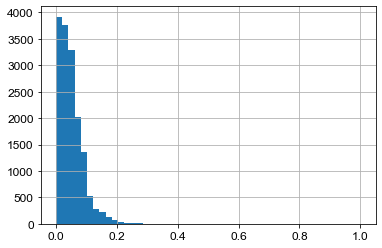

In [99]:
uridylated_results['freq'].hist(bins=np.linspace(0, 1, 50))

In [118]:
df = pd.merge(uridylated_results, tpc_half_life, on='gene_id')

In [119]:
pearsonr(df['freq'], df['t1/2'])

(-0.08759075924975708, 1.9820681762476744e-20)

# Cytosin

In [101]:
# multi run

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'

results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in gene_model.index:
        results.append(e.submit(get_nucleotide_freq, infile, gene_id, 'C'))

In [102]:
cytosin_results = []
for res in results:
    result = res.result()
    if result[1] >= 10:
        cytosin_results.append(result)

In [103]:
cytosin_results = pd.DataFrame(cytosin_results, columns=['nucleotide_count', 'total_count', 'gene_id'])

In [104]:
cytosin_results['freq'] = cytosin_results['nucleotide_count']/cytosin_results['total_count']

<AxesSubplot:>

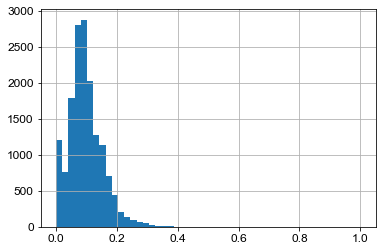

In [105]:
cytosin_results['freq'].hist(bins=np.linspace(0, 1, 50))

In [120]:
df = pd.merge(cytosin_results, tpc_half_life, on='gene_id')

In [121]:
pearsonr(df['freq'], df['t1/2'])

(-0.07513986351726257, 1.981618725398178e-15)

# guanylated

In [106]:
# multi run

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'

results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in gene_model.index:
        results.append(e.submit(get_nucleotide_freq, infile, gene_id, 'G'))

In [107]:
guanylated_results = []
for res in results:
    result = res.result()
    if result[1] >= 10:
        guanylated_results.append(result)

In [108]:
guanylated_results = pd.DataFrame(guanylated_results, columns=['nucleotide_count', 'total_count', 'gene_id'])

In [109]:
guanylated_results['freq'] = guanylated_results['nucleotide_count']/guanylated_results['total_count']

<AxesSubplot:>

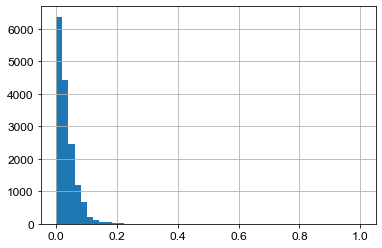

In [110]:
guanylated_results['freq'].hist(bins=np.linspace(0, 1, 50))

In [122]:
df = pd.merge(guanylated_results, tpc_half_life, on='gene_id')

In [123]:
pearsonr(df['freq'], df['t1/2'])

(-0.03852173899862705, 4.7498501632661175e-05)

In [726]:
get_nucleotide_freq(infile, 'AT3G22530', 'G', log=True)

AAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAATAAAAATAAAAAAATAAAAAAAAAAAAAAAAAATAAAAAATAAAAATAAAAAAATAAAAAAAATAAAAAAAAAAAAAATAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

(0, 33, 'AT3G22530')

In [153]:
import seqlogo

In [151]:
n = 0
count = Counter()
for read_id in polya_seq_dict:
    seq = polya_seq_dict[read_id][-5:]
    if seq.count('A') != 5:
        count[seq] += 1

In [ ]:
count.most_common()

In [156]:
def get_base_freq(kmer, kmer_len=5):
    freq = {
        'A': np.zeros(kmer_len), 
        'C': np.zeros(kmer_len),
        'G': np.zeros(kmer_len),
        'T': np.zeros(kmer_len)
        }
    for k in kmer.most_common():
        for n, base in enumerate(k[0]):
            freq[base][n] += k[1]
    
    freq = pd.DataFrame(freq)
    freq = freq.div(freq.sum(axis=1), axis=0)
    ppm = seqlogo.Ppm(freq)
    return ppm

In [158]:
ppm = get_base_freq(count)